In [1]:
# Set up the default parameters
# 1. The code block will be shown in the document
# 2. set up figure display size
# 3. turn off all the warnings and messages

knitr::opts_chunk$set(echo = TRUE)
knitr::opts_chunk$set(fig.width = 8, fig.height = 4)
knitr::opts_chunk$set(warning = FALSE, message = FALSE)


# Background

We have explored how various U.S. economic indicators are related to each other, which is a classic application for the VAR modeling. In this problem, we will study the inter-dependence and Granger causality between various economic indicators.

# Instructions on reading the data

To read the data in `R`, save the file in your working directory (make sure you have changed the directory if different from the R working directory) and read the data using the `R` function `read.csv()`


In [25]:
# Read the monthly and quarterly data
data <- read.csv('QDataR.csv')
data2 <- read.csv('MDataR.csv')
date.quarter <- as.Date(data[,1],"%m/%d/%Y")
date.month <- as.Date(data2[,1],"%m/%d/%Y")

Here are the libraries you will need:



In [26]:
library(data.table)
library(vars)
library(xts)
library(mgcv)
library(stats)
library(tseries)
library(aod)
library(mvtsplot)

# Question 1: Univariate Analysis

## Question 1a

Plot the time series of all indicators for comparison and discuss whether you find any similarities in terms of trend or other features. Plot also the 1st order difference plots and the corresponding ACF plots. Interpret in terms of stationarity and volatility.

Keep in mind, 2 variables have monthly data, while three have quarterly data. You will need to standardise all into quarterly data time series in order to effectively answer all questions below.


In [22]:
# transform into time series
gdp.ts <- xts(data$GDP, date.quarter)
expgs.ts <- xts(data$EXPGS, date.quarter)
imgpgsc.ts <- xts(data$IMPGSC1, date.quarter)
unrate.ts <- xts(data2$UNRATE, date.month)
pce.ts <- xts(data2$PCE, date.month)

# merge into multivariate time series
ts.merge <- merge(gdp.ts, expgs.ts, join = 'inner')
ts.merge <- merge(ts.merge, imgpgsc.ts, join = 'inner')
ts.merge <- merge(ts.merge, unrate.ts, join = 'inner')
ts.merge <- merge(ts.merge, pce.ts, join = 'inner')
colnames(ts.merge) <- c("tsgdp", "tsexpgs", "tsimgpsc", "tsunrate", "tspce")

head(ts.merge)

             tsgdp tsexpgs tsimgpsc tsunrate tspce
1959-01-01 510.330  21.915  129.446      6.0 306.1
1959-04-01 522.653  21.776  135.745      5.2 312.2
1959-07-01 525.034  24.079  137.041      5.1 317.8
1959-10-01 528.600  23.131  133.561      5.7 322.8
1960-01-01 542.648  26.145  138.606      5.2 323.6
1960-04-01 541.080  26.850  139.636      5.2 336.5

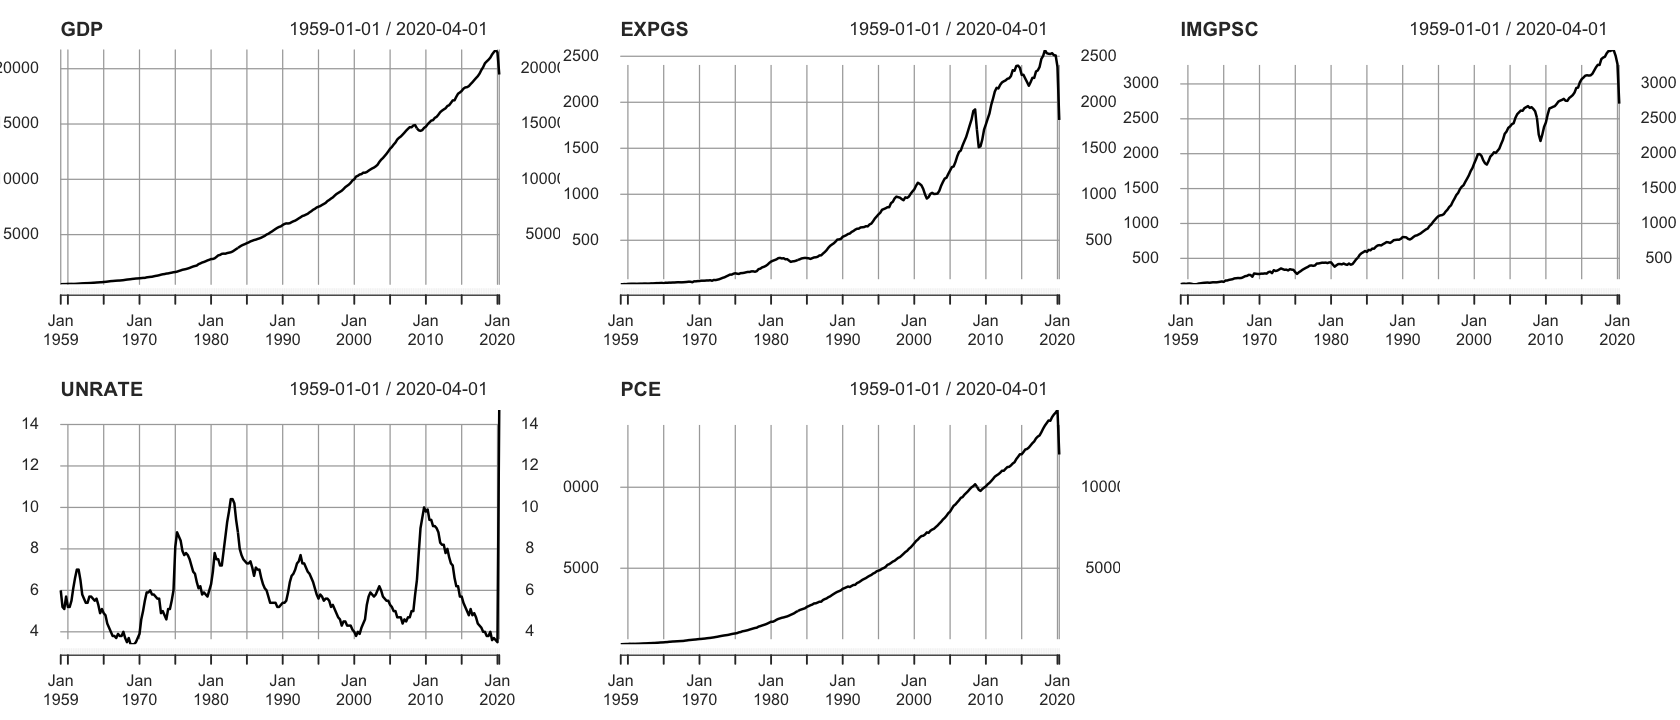

In [38]:
options(repr.plot.width=14, repr.plot.height=6)
par(mfrow=c(2,3))

plot(ts.merge$tsgdp, main="GDP")
plot(ts.merge$tsexpgs, main="EXPGS")
plot(ts.merge$tsimgpsc, main="IMGPSC")
plot(ts.merge$tsunrate, main="UNRATE")
plot(ts.merge$tspce, main= "PCE")

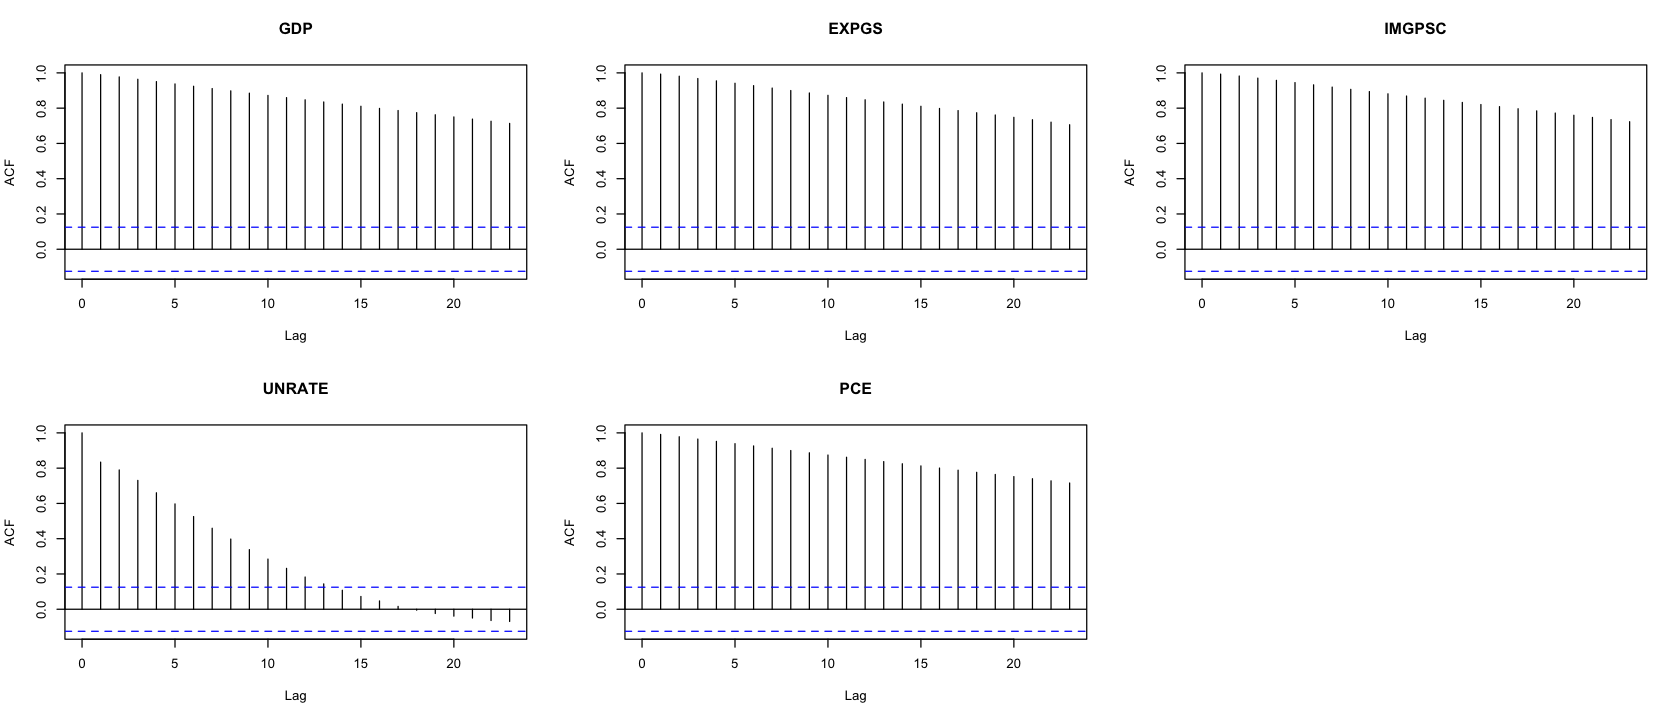

In [40]:
options(repr.plot.width=14, repr.plot.height=6)
par(mfrow=c(2,3))

acf(ts.merge$tsgdp, main="GDP")
acf(ts.merge$tsexpgs, main="EXPGS")
acf(ts.merge$tsimgpsc, main="IMGPSC")
acf(ts.merge$tsunrate, main="UNRATE")
acf(ts.merge$tspce, main= "PCE")

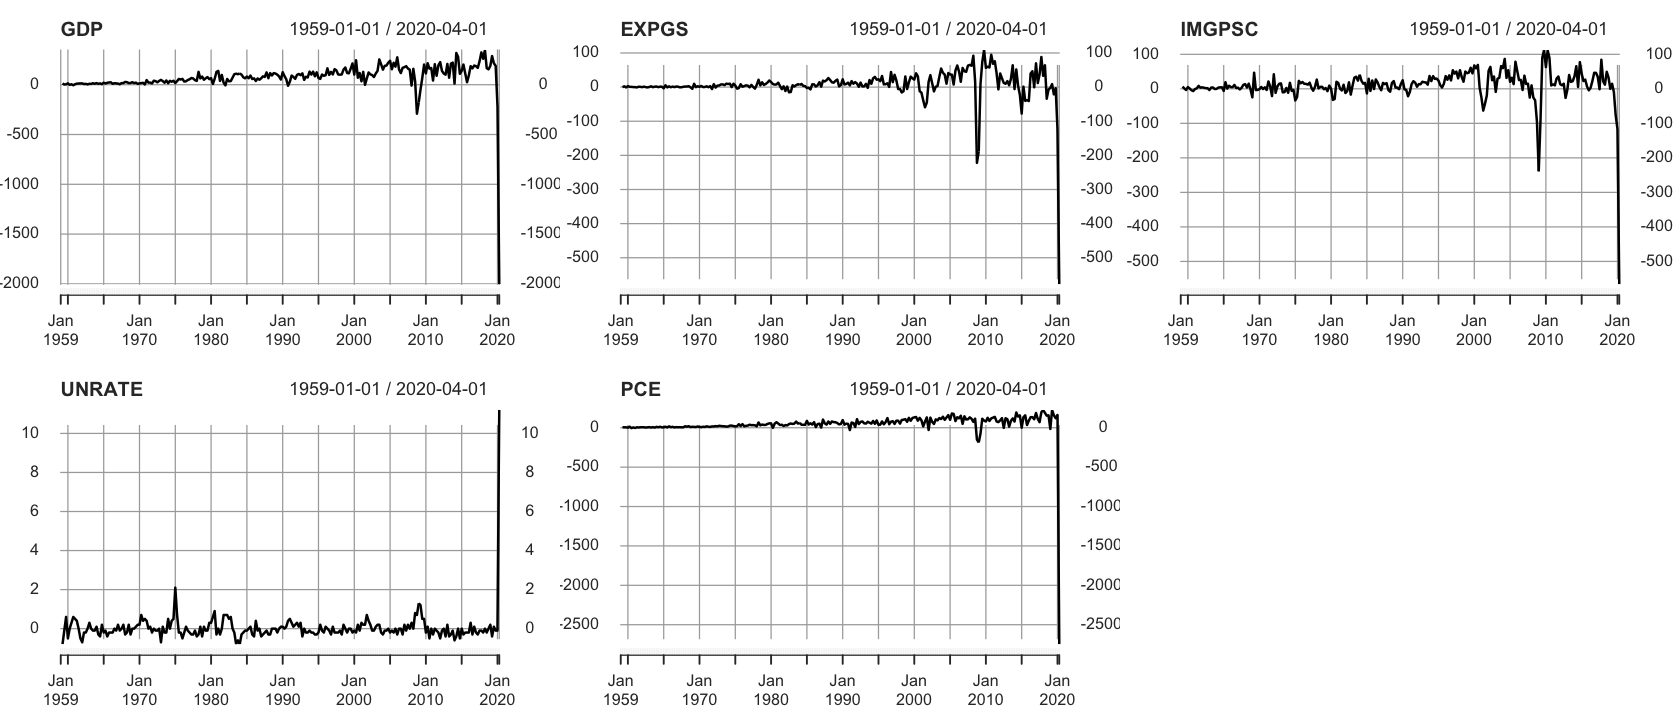

In [39]:
options(repr.plot.width=14, repr.plot.height=6)
par(mfrow=c(2,3))

plot(diff(ts.merge$tsgdp), main="GDP")
plot(diff(ts.merge$tsexpgs), main="EXPGS")
plot(diff(ts.merge$tsimgpsc), main="IMGPSC")
plot(diff(ts.merge$tsunrate), main="UNRATE")
plot(diff(ts.merge$tspce), main= "PCE")

*Response*

**Stationarity**

Using the ACF plots all time series are not stationary because all autocorrelation are outside teh confidence intervals. There does seem to be trend in the data where the ACF drops for higher lags in all times series.

**Volitility**

The volitility can be captured by examining the differenced data. All time-series show a high level of volitility at the start of 2020 given the COVID pandemic. Further, all times series show an impact in 2008 from the housing market collapse. The GDP, EXPGS, and IMGPSC had the highest voliliity during this time whereas UNRATE and PCE were not as volitile. For other periods the volitility of GDP, EXPGS, IMGPSC and PCE were low before 2000 after which the volitility increased. The volility of UNRATE is the same across all time periods except for the COVID pandemic.

**Trend**

The trend is captured through visual examination of the raw datasets. All sereies excpet unrate show a steady increase across time with small drops given the market periods of the tiem. There is not clear seasonality in these series. On the other hand there does not seem to be a consistent postive or negative trend in the UNRATE dataset. There does seem to be fluctuations in the data that could be consistent with seasonality.

## Question 1b

Using the original, undifferenced data, divide the GDP data into training data including the data for years 1959 to 2019 with the last two quarters being the testing data. Fit the trend using the splines regression to the GDP training time series. Then, apply ARMA to the residuals obtained from this splines fitting. Use max order of 6. Evaluate goodness of fit for the ARMA model. Forecast the first two quarters of 2020 (testing data) and compare to the observed values. Discuss why there are (or not!) significant differences between predicted vs observed. To do this, you should also evaluate the prediction intervals with a 95% confidence level.

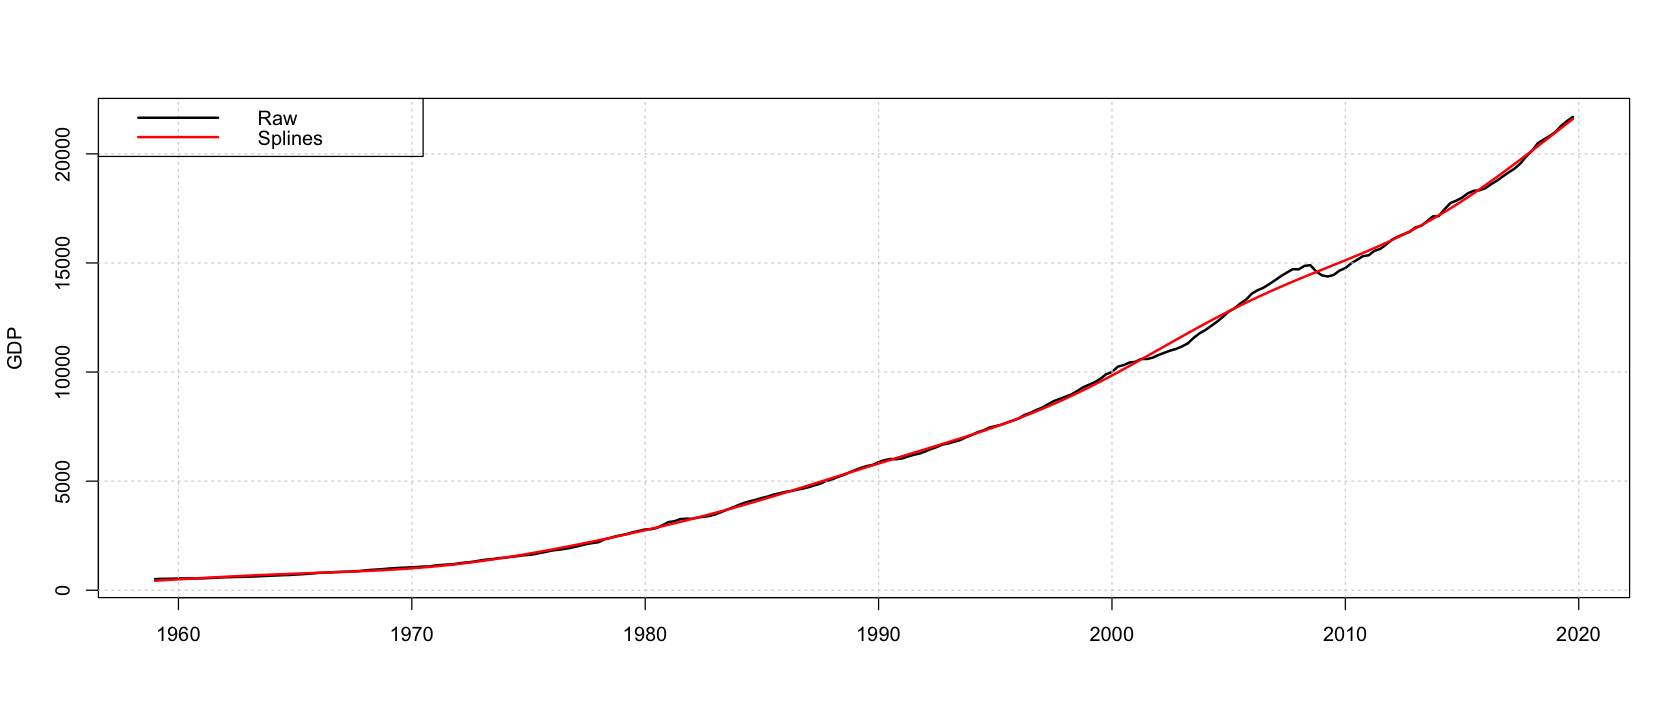

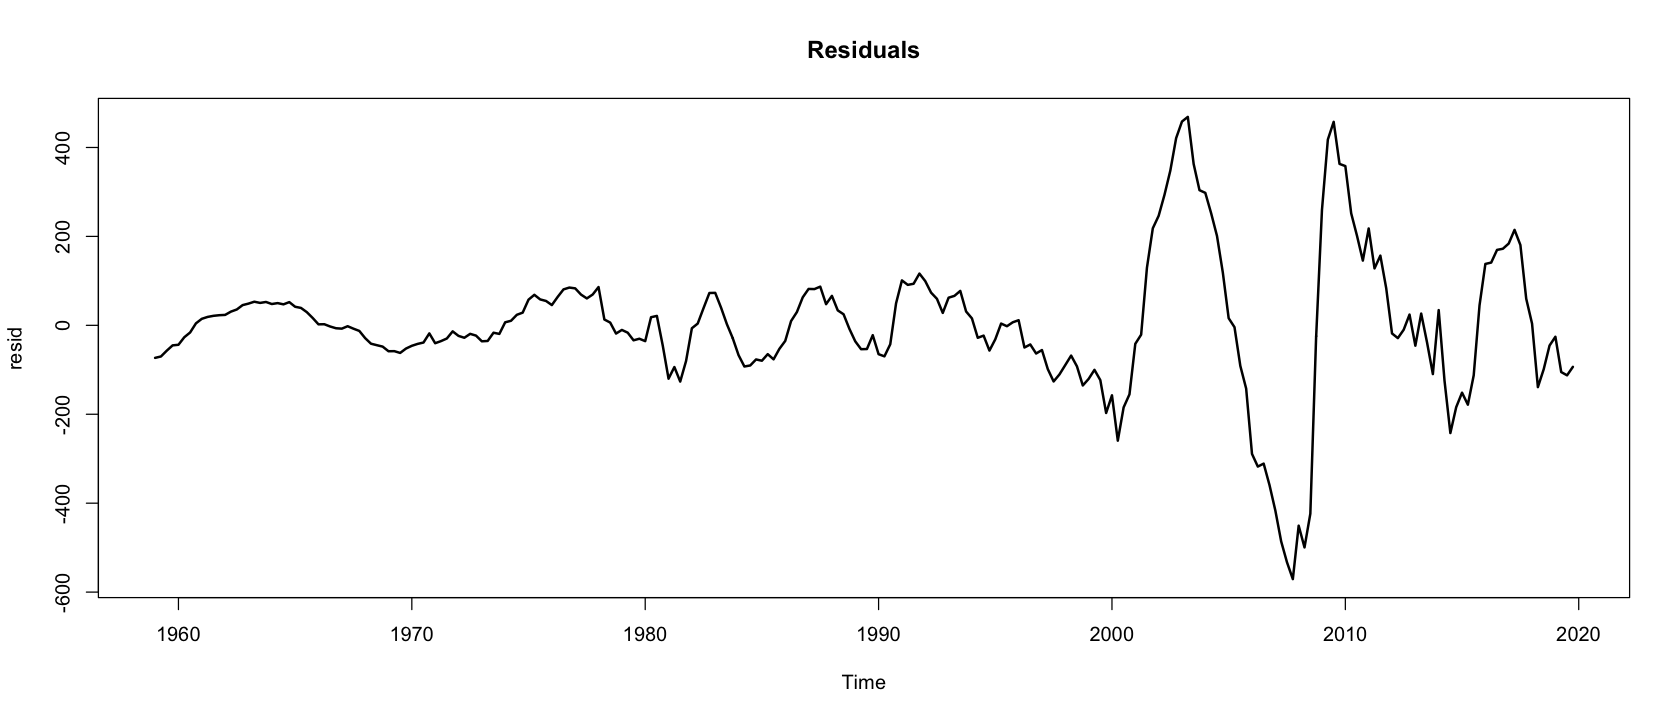

In [127]:
ts.merge.gdp.test = ts.merge$tsgdp["2020"]
ts.merge.gdp.train = ts.merge$tsgdp["1959/2019"]
ts.merge.gdp.train = ts(ts.merge.gdp.train$tsgdp, frequency=4, start=c(1959,1,1))
ts.merge.gdp.test = ts(ts.merge.gdp.test$tsgdp, frequency=4, start=c(2020,1,1))

points <- 1:nrow(ts.merge.gdp.train)
points <- (points - min(points)) / max(points)

gam.gdp <- gam(ts.merge.gdp.train ~ s(points))
gam.gdp.fitted <- ts(fitted(gam.gdp), frequency=4, start=c(1959,1,1))

ts.plot(ts.merge.gdp.train, lwd=2, col="black", ylab="GDP", xlab="")
grid()
lines(gam.gdp.fitted, lwd=2, col="red")
legend("topleft", legend = c("Raw", "Splines"),
col = c("black", "red"), lwd = 2)

resid <- gam.gdp.fitted - ts.merge.gdp.train
ts.plot(resid, lwd=2, col="black", main="Residuals")

gdp.pred = ts(tail(predict(gam.gdp, n.ahead=2), n=2), frequency=4, start=c(2020,1,1))
gdp.resid.test = gdp.pred - ts.merge.gdp.test

In [104]:
n_fit=length(residuals)
n=length(residuals)
n_forward=n-n_fit

norder = 6
orders = data.frame()
p = c(0:norder); q = c(0:norder)
aic = matrix(0,norder,norder)
for(i in 1:norder){
for(j in 1:norder){
tryCatch( {modij = stats::arima(resid,order = c(p[i],0,q[j]), method='ML') },
         error = function(e) {return(NA)} )
current.aic=modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
orders<-rbind(orders,c(p[i],q[j],current.aic))
}
}
names(orders) <- c("p","q","AIC")
# Extract the "best" one according to AIC
orders[which.min(orders$AIC),]

Warning message in stats::arima(resid, order = c(p[i], 0, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(resid, order = c(p[i], 0, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(resid, order = c(p[i], 0, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(resid, order = c(p[i], 0, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”


,p,q,AIC
,<dbl>,<dbl>,<dbl>
36,5,5,2557.152


Warning message in stats::arima(resid, order = c(5, 0, 5), method = "ML"):
“possible convergence problem: optim gave code = 1”


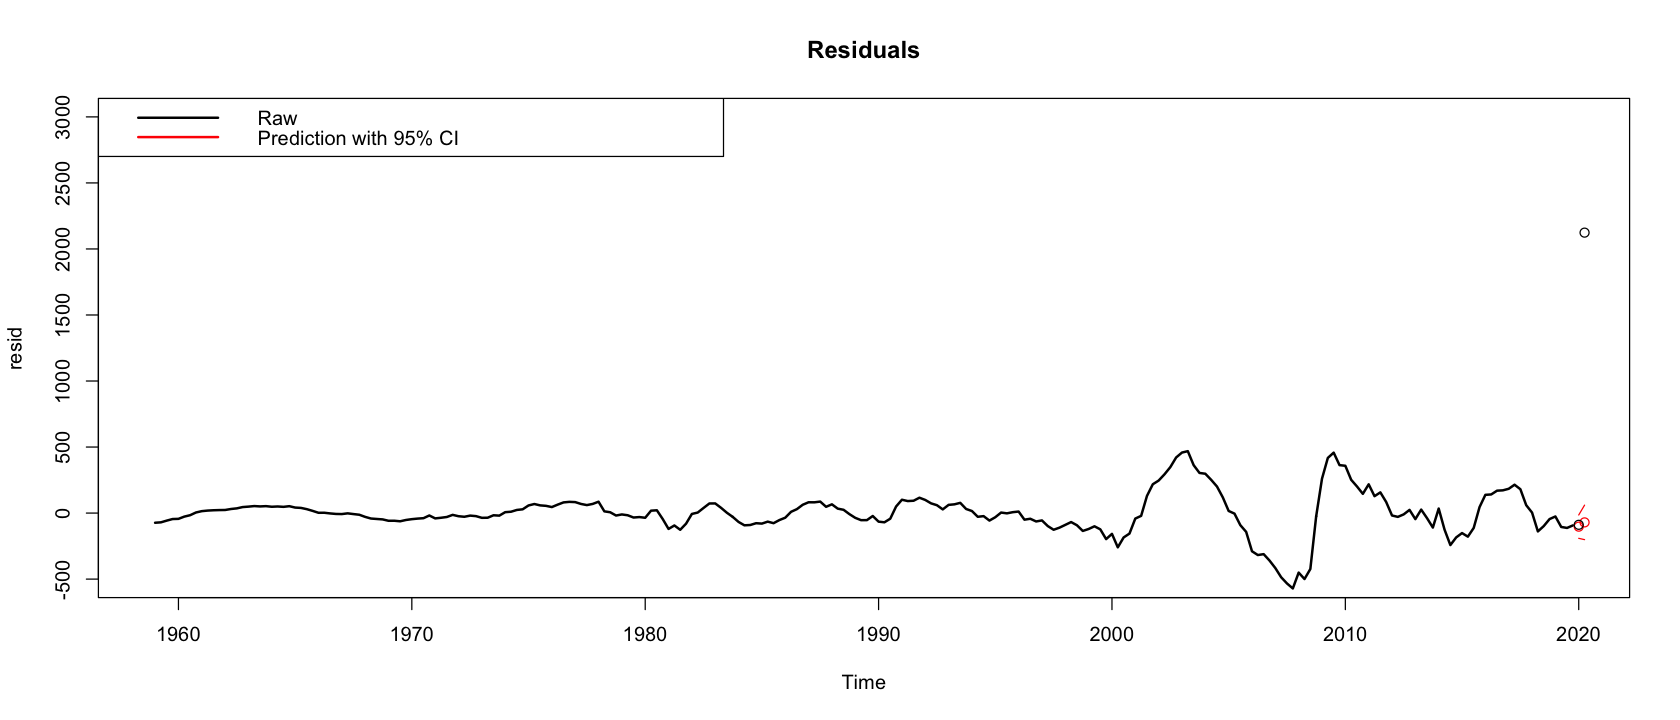


	Box-Pierce test

data:  residuals.arima$resid
X-squared = 6.267, df = 1, p-value = 0.0123



	Box-Ljung test

data:  residuals.arima$resid
X-squared = 6.5323, df = 1, p-value = 0.01059


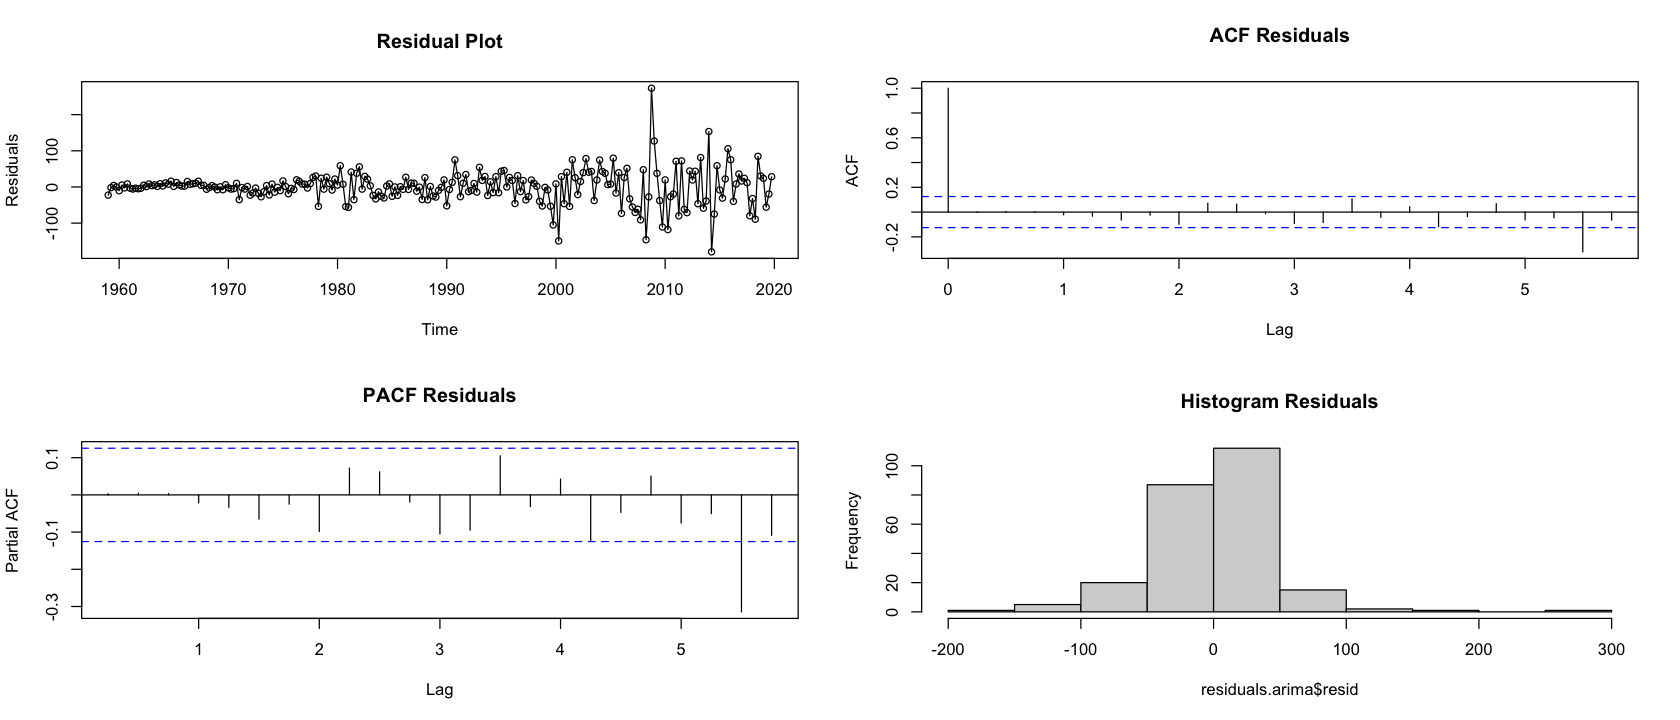

In [155]:
residuals.arima = stats::arima(resid,order = c(5,0,5), method='ML')
outpred = predict(residuals.arima, n.ahead=2)
ubound = ts(outpred$pred+1.96*outpred$se, start=c(2020,1,1), frequency=4)
lbound = ts(outpred$pred-1.96*outpred$se, start=c(2020,1,1), frequency=4)

ts.plot(resid, lwd=2, col="black", main="Residuals",ylim=c(-500, 3000))
points(outpred$pred, col="red")
points(gdp.resid.test, col="black")
lines(ubound, col="red")
lines(lbound,col="red")
legend("topleft", legend = c("Raw", "Prediction with 95% CI"),
col = c("black", "red"), lwd = 2)

par(mfrow = c(2, 2))
plot(residuals.arima$resid, ylab="Residuals", type="o", main = "Residual Plot")
acf(residuals.arima$resid, main = "ACF Residuals")
pacf(residuals.arima$resid, main = "PACF Residuals")
hist(residuals.arima$resid, main = "Histogram Residuals")
Box.test(residuals.arima$resid, lag = (11), type="Box-Pierce", fitdf=(10))
Box.test(residuals.arima$resid, lag = (11), type="Ljung-Box", fitdf=(10))

*Response*

**Observations**

The actual data for first quarter of 2020 is within the 95% confidence interval and is reasonably close to the predicted value. However, due to the COVID pandemic in the second quarter of 2020 the predicted value deviates significantly from the observed.

**Goodness Of Fit**

I evaluated the goodness of fit using the residual plot, ACF plot, PACF plot, and histogram of residuals. Overall the ACF and PACF plots resemble whilte noise and the residuals are reasonably normal about 0. Further the tests for serial correlation are less than 0.05 indicated we reject the null hypothesis that the data is not serially correlated.

## Question 1c 

Perform a similar analysis as in (1b) but this time applying ARIMA to the GDP time series training dataset. Compare the forecast and discuss why these are different or similar from the testing data. Assume p,q belong to [0,5] and d belongs to [0,1]. Also evaluate the prediction intervals with a 95% confidence level, and compare the results of the forecast with the analysis in Question 1b.

In [156]:
n_fit=length(ts.merge.gdp.train)
n=length(ts.merge.gdp.train)
n_forward=n-n_fit

norder = 5
orders = data.frame()
p = c(0:norder); q = c(0:norder)
aic = matrix(0,norder,norder)
for(i in 1:norder){
for(j in 1:norder){
tryCatch( {modij = stats::arima(ts.merge.gdp.train,order = c(p[i],0,q[j]), method='ML') },
         error = function(e) {return(NA)} )
current.aic=modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
orders<-rbind(orders,c(p[i],q[j],current.aic))
}
}
names(orders) <- c("p","q","AIC")
# Extract the "best" one according to AIC
orders[which.min(orders$AIC),]

norder = 5
orders = data.frame()
p = c(0:norder); q = c(0:norder)
aic = matrix(0,norder,norder)
for(i in 1:norder){
for(j in 1:norder){
tryCatch( {modij = stats::arima(ts.merge.gdp.train,order = c(p[i],1,q[j]), method='ML') },
         error = function(e) {return(NA)} )
current.aic=modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
orders<-rbind(orders,c(p[i],q[j],current.aic))
}
}
names(orders) <- c("p","q","AIC")
# Extract the "best" one according to AIC
orders[which.min(orders$AIC),]

Warning message in stats::arima(ts.merge.gdp.train, order = c(p[i], 0, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”
Warning message in log(s2):
“NaNs produced”
Warning message in log(s2):
“NaNs produced”
Warning message in log(s2):
“NaNs produced”
Warning message in stats::arima(ts.merge.gdp.train, order = c(p[i], 0, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”
Warning message in log(s2):
“NaNs produced”
Warning message in stats::arima(ts.merge.gdp.train, order = c(p[i], 0, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”
Warning message in log(s2):
“NaNs produced”
Warning message in log(s2):
“NaNs produced”
Warning message in log(s2):
“NaNs produced”
Warning message in log(s2):
“NaNs produced”
Warning message in log(s2):
“NaNs produced”
Warning message in log(s2):
“NaNs produced”
Warning message in log(s2):
“NaNs produced”
Warning message in log(s2):
“NaNs produced”


,p,q,AIC
,<dbl>,<dbl>,<dbl>
22,4,1,2652.436


Warning message in stats::arima(ts.merge.gdp.train, order = c(p[i], 1, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(ts.merge.gdp.train, order = c(p[i], 1, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(ts.merge.gdp.train, order = c(p[i], 1, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”
Warning message in log(s2):
“NaNs produced”
Warning message in log(s2):
“NaNs produced”
Warning message in stats::arima(ts.merge.gdp.train, order = c(p[i], 1, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(ts.merge.gdp.train, order = c(p[i], 1, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(ts.merge.gdp.train, order = c(p[i], 1, q[j]), method = "ML"):
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(ts.m

,p,q,AIC
,<dbl>,<dbl>,<dbl>
13,2,2,2647.693


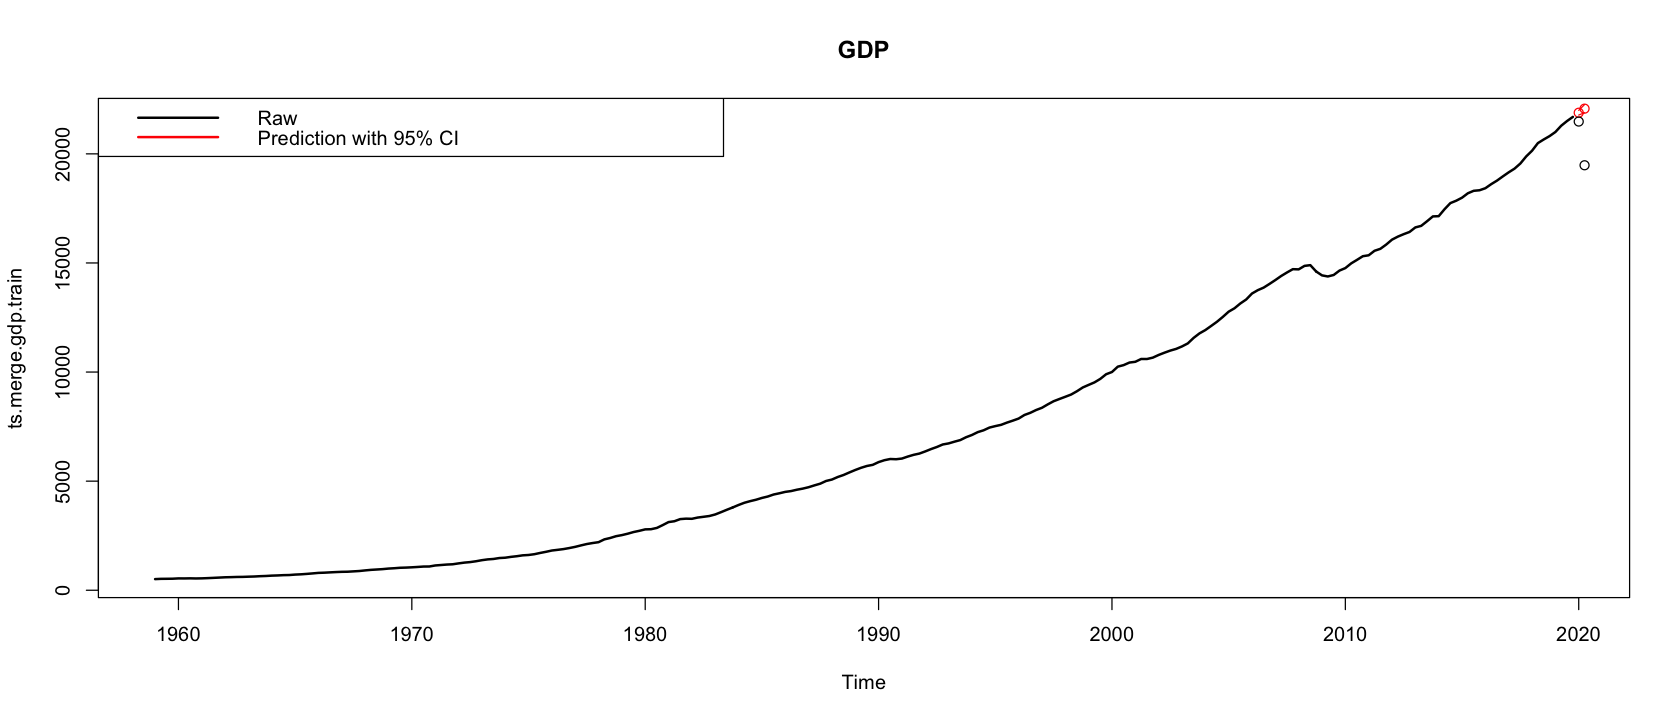


	Box-Pierce test

data:  gdp.arima$resid
X-squared = 1.9907, df = 1, p-value = 0.1583



	Box-Ljung test

data:  gdp.arima$resid
X-squared = 2.0439, df = 1, p-value = 0.1528


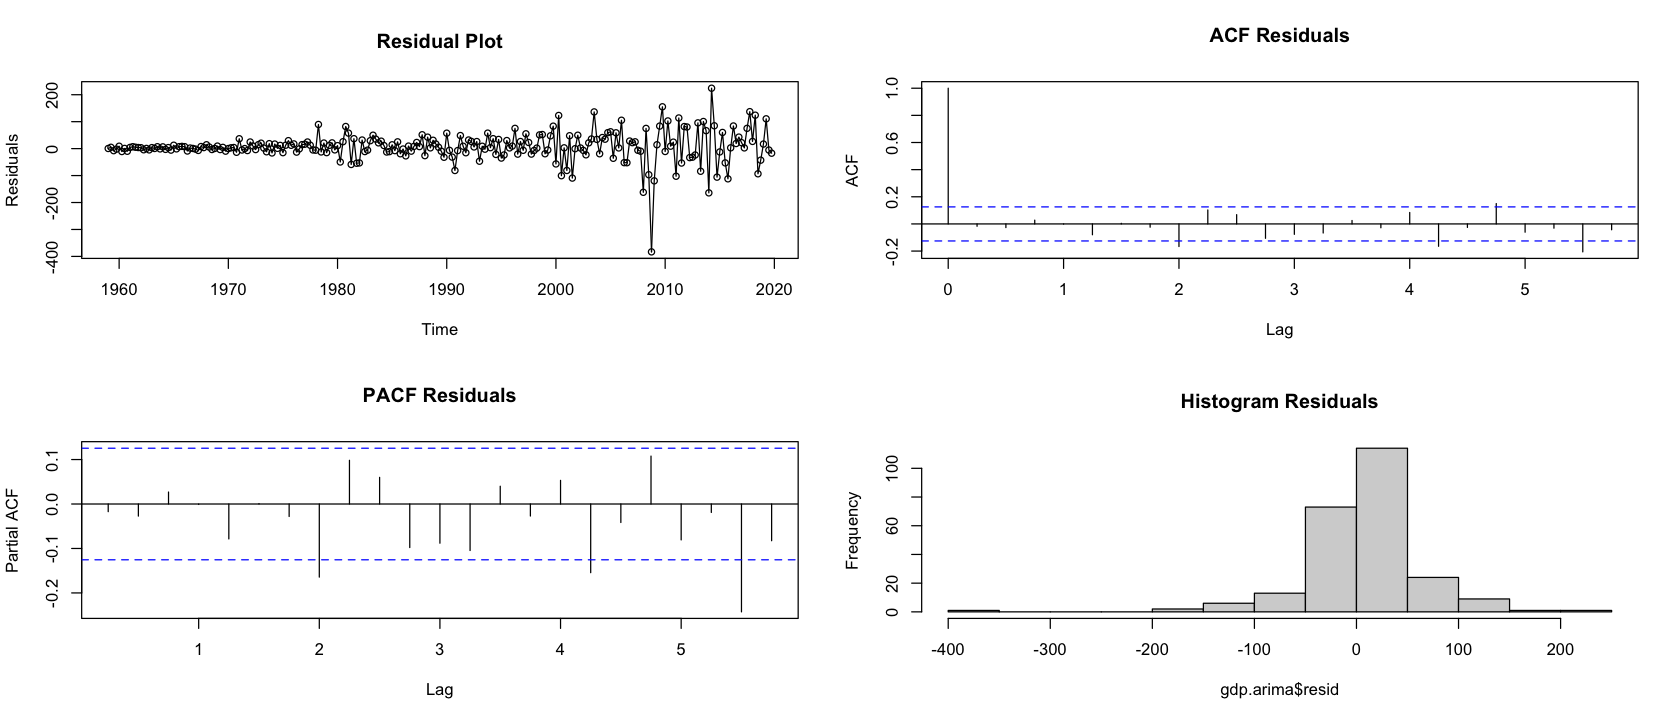

In [160]:
gdp.arima = stats::arima(ts.merge.gdp.train,order = c(2,1,2), method='ML')
outpred = predict(gdp.arima, n.ahead=2)
ubound = ts(outpred$pred+1.96*outpred$se, start=c(2020,1,1), frequency=4)
lbound = ts(outpred$pred-1.96*outpred$se, start=c(2020,1,1), frequency=4)

ts.plot(ts.merge.gdp.train, lwd=2, col="black", main="GDP")
points(outpred$pred, col="red")
points(ts.merge.gdp.test, col="black")
lines(ubound, col="red")
lines(lbound,col="red")
legend("topleft", legend = c("Raw", "Prediction with 95% CI"),
col = c("black", "red"), lwd = 2)

par(mfrow = c(2, 2))
plot(gdp.arima$resid, ylab="Residuals", type="o", main = "Residual Plot")
acf(gdp.arima$resid, main = "ACF Residuals")
pacf(gdp.arima$resid, main = "PACF Residuals")
hist(gdp.arima$resid, main = "Histogram Residuals")
Box.test(gdp.arima$resid, lag = (5), type="Box-Pierce", fitdf=(4))
Box.test(gdp.arima$resid, lag = (5), type="Ljung-Box", fitdf=(4))

*Response*

**Analysis**

The predictional values of the ARIMA model for GDP follow a similar trend to the overall dataset. Where the predictions indicate a higher GDP quarter-over-quarter. Of course this is not in line with the actual data where there is a sharp decrease in GDP due to the COVID pandemic. This is similar to the result uncovered in the residual analysis is question 1B.

**Goodness of Fit**

The model displays good fit to the data as evidenced by the normal distribution of residuals and white noise ACF and PACF plots. The tests for serial correlation indicate that we fail to reject the null hypothesis of no serial correlation.

# Question 2: Multivariate Analysis using VAR modeling

For this question, divide the quarterly data into training data (excluding the first two quarters of 2020) and testing data (including the two quarters). You will apply the modeling to the training data, and we will forecast the first two quarters of 2020.

## Question 2a

Apply the VAR model to the multivariate time series including all five economic indicators observed quarterly. (Note that you will apply VAR to the training data.) Identify the VAR order using both AIC and BIC and compare. If the selected order using AIC is larger than the selected order than selected using BIC, apply the Wald test to evaluate whether a smaller order than the one selected with AIC would be a better choice, meaning the smaller order model would perform similarly than the larger order model. Interpret the order selection.

This can be done by following the below substeps:-
1)Combine the variables into a multivariate dataset
2)select/display var orders and isolate models using AIC and BIC orders 
3)Isolate coefficients and covariances from the AIC model
4)applying the Wald test to the values obtained from the AIC model, but would not be present in the BIC model. You can run a single Wald test for each variable, with all the lagged coefficients for that particular variable, in all resulting in 5 wald tests.

In [168]:
ts.merge.test = ts.merge["2020"]
ts.merge.train = ts.merge["1959/2019"]

VARselect(ts.merge.train, lag.max = 15)$selection

model.var.aic <- VAR(ts.merge.train, p=7)
model.var.sc <- VAR(ts.merge.train, p=2)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     7      3      2      7

*Response*

## Question 2b

Based on the analysis in 2a, select the VAR order using BIC and fit that model. Print out the model summary and comment on the statistical significance of the coefficients. Apply a model selection analysis using stepwise regression to select the models for each individual time series. What do you conclude from this model selection? Apply the restrict() command in R to restrict the model of order. How do the restricted models compare?

Follow the below steps to implement this:
1)Analyze the coefficients of the unrestricted model.
2)Then treat each of the series separately and do a stepwise regression by apply lm() and step() (in the backward direction with 3 steps) functions to each of the component time series to examine the coefficients
3)The stepwise regressions will return three separate models. Analyze if the same coefficients are significant in the overall VAR versus each of the stepwise models. Discuss.
4)Then build a model using restrict and see which predictors were significant in the restricted VAR model.

In [170]:
model.var.sc <- VAR(ts.merge.train, p=2)
summary(model.var.sc)


VAR Estimation Results:
Endogenous variables: tsgdp, tsexpgs, tsimgpsc, tsunrate, tspce 
Deterministic variables: const 
Sample size: 242 
Log Likelihood: -4590.213 
Roots of the characteristic polynomial:
1.009 0.9786 0.9786 0.9495 0.8059 0.8059 0.3523 0.3523 0.2171 0.02384
Call:
VAR(y = ts.merge.train, p = 2)


Estimation results for equation tsgdp: 
tsgdp = tsgdp.l1 + tsexpgs.l1 + tsimgpsc.l1 + tsunrate.l1 + tspce.l1 + tsgdp.l2 + tsexpgs.l2 + tsimgpsc.l2 + tsunrate.l2 + tspce.l2 + const 

             Estimate Std. Error t value Pr(>|t|)    
tsgdp.l1      1.24053    0.08407  14.756  < 2e-16 ***
tsexpgs.l1   -0.05900    0.15708  -0.376   0.7075    
tsimgpsc.l1   0.61018    0.14409   4.235 3.31e-05 ***
tsunrate.l1 -13.88253   10.74571  -1.292   0.1977    
tspce.l1     -0.04535    0.12278  -0.369   0.7122    
tsgdp.l2     -0.20571    0.09197  -2.237   0.0263 *  
tsexpgs.l2   -0.02598    0.15757  -0.165   0.8692    
tsimgpsc.l2  -0.62147    0.14569  -4.266 2.91e-05 ***
tsunrate.l2  15.

*Response*

## Question 2c

Evaluate the goodness of fit for the restricted BIC model using the multivariate ARCH test, the Jarque-Bera test and the Portmanteau test. State which assumptions are satisfied, and which are violated. (Note: While we evaluate the residuals for the normality assumption, we do not necessarily assume normality of the data. We use the normality assumption if we use the t-test to evaluate statistical significance.)

In [172]:
model.var.sc.restrict <- restrict(model.var.sc)
summary(model.var.sc.restrict)


VAR Estimation Results:
Endogenous variables: tsgdp, tsexpgs, tsimgpsc, tsunrate, tspce 
Deterministic variables: const 
Sample size: 242 
Log Likelihood: -4602.489 
Roots of the characteristic polynomial:
 1.01 0.9788 0.9788 0.9499 0.7277 0.7277 0.6145 0.3687 0.2019 0.05747
Call:
VAR(y = ts.merge.train, p = 2)


Estimation results for equation tsgdp: 
tsgdp = tsgdp.l1 + tsexpgs.l1 + tsimgpsc.l1 + tsgdp.l2 + tsimgpsc.l2 

            Estimate Std. Error t value Pr(>|t|)    
tsgdp.l1     1.26315    0.06356  19.872  < 2e-16 ***
tsexpgs.l1  -0.09372    0.02277  -4.117 5.31e-05 ***
tsimgpsc.l1  0.65870    0.12648   5.208 4.14e-07 ***
tsgdp.l2    -0.24017    0.06469  -3.713 0.000256 ***
tsimgpsc.l2 -0.68957    0.12694  -5.432 1.38e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 50.91 on 237 degrees of freedom
Multiple R-Squared:     1,	Adjusted R-squared:     1 
F-statistic: 1.756e+06 on 5 and 237 DF,  p-value: < 2.2e-16 


Estimation r

In [179]:
arch.test(model.var.sc.restrict)


	ARCH (multivariate)

data:  Residuals of VAR object model.var.sc.restrict
Chi-squared = 2238.6, df = 1125, p-value < 2.2e-16

$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object model.var.sc.restrict
Chi-squared = 2238.6, df = 1125, p-value < 2.2e-16



In [176]:
jarque.bera.test(model.var.sc.restrict$resid)


	Jarque Bera Test

data:  model.var.sc.restrict$resid
X-squared = NaN, df = 2, p-value = NA


In [178]:
serial.test(model.var.sc.restrict, lags.pt=10, type='PT.asymptotic')


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object model.var.sc.restrict
Chi-squared = 392.44, df = 200, p-value = 1.243e-14

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object model.var.sc.restrict
Chi-squared = 392.44, df = 200, p-value = 1.243e-14



*Response*

## Question 2d

Using the VAR model with the order selected using BIC, forecast the first two quarters of 2020 using the unrestricted and restricted VAR. Include 95% confidence intervals. Compare the predictions to the observed data. (You don't need to plot them (but can if you'd like).  Using mean absolute percentage error and the precision measure, compare the predictions for GDP derived from the univariate analysis (Question 1) and this multivariate analysis. Discuss on the differences or similarities.

In [203]:
outpred = predict(model.var.sc,n.ahead=2)
outpred.restrict = predict(model.var.sc.restrict,n.ahead=2)

MAPE.unrestricted = mean(abs(outpred$fcst$tsgdp[,1]-ts.merge.gdp.test)/ts.merge.gdp.test)
MAPE.restricted = mean(abs(outpred.restrict$fcst$tsgdp[,1]-ts.merge.gdp.test)/ts.merge.gdp.test)
PM.unrestricted = sum((outpred$fcst$tsgdp[,1]-ts.merge.gdp.test)^2)/sum((ts.merge.gdp.test-mean(ts.merge.gdp.test))^2)
PM.restricted = sum((outpred.restrict$fcst$tsgdp[,1]-ts.merge.gdp.test)^2)/sum((ts.merge.gdp.test-mean(ts.merge.gdp.test))^2)

paste("MAPE Unrestricted:", MAPE.unrestricted)
paste("MAPE Restricted:", MAPE.restricted)
paste("PM Unrestricted:", PM.unrestricted)
paste("PM Restrictred:", PM.restricted)

[1] "MAPE Unrestricted: 0.0736218102235909"

[1] "MAPE Restricted: 0.0743554267452573"

[1] "PM Unrestricted: 3.283044109323"

[1] "PM Restrictred: 3.34570798532595"

*Response*

## Question 2e

Perform a Granger Causality analysis using Wald test to evaluate whether any of the economic indicators lead GDP. Would any of the indicators help in predicting or explaining GDP for next quarters? Provide your interpretation based on the Granger causality as well as for forecasting comparison in (2d).For this, use the unrestricted bic model from Question 2a.

*Response*

# Question 3

For this question, consider the training data to include the time values up to December 2017 and the testing data to include the first two quarters of 2018.

## Question 3a

Apply the VAR modeling approach with the order selected using the BIC approach giving the unrestricted VAR model. Apply a model selection analysis using stepwise regression to select the models for each individual time series. Based on the selected models, form the restricted VAR model, much like what was presented in the Moose R example code. Compare these two models in terms of coefficients and their statistical significance with the models derived in Question 2.


Follow the below steps to implement this:
1)Analyze the coefficients of the unrestricted model.
2)Then treat each of the series separately and do a stepwise regression by apply lm() and step()(in the backward direction with 3 steps) functions to each of the component time series to examine the coefficients
3)The stepwise regressions will return three separate models. Analyze if the same coefficients are significant in the overall VAR versus each of the stepwise models. Discuss.
4)Then build a model using restrict and see which predictors were significant in the restricted VAR model.

*Response*

## Question 3b

Forecast the first two quarters of 2018 using the unrestricted and restricted VAR models derived in (3a). Include 95% confidence intervals. Compare the predictions to the observed data using mean absolute percentage error and the precision measure for GDP. Compare the predictions to those derived in (2d). Comment on the accuracy of the predictions.

*Response*

## Question 3c

Perform a Granger Causality analysis using Wald test to evaluate whether any of the economic indicators lead GDP. Would any of the indicators help in predicting or explaining GDP for next quarters? Provide your interpretation based on the Granger causality as well as for forecasting comparison in (3b). Compare this analysis with the findings in (2e). For this question, use the unrestricted VAR model from Question 3a.

*Response*

# Question 4: Reflection

From what you encountered above and your conceptual understanding of VAR modelling, reflect on the relative strengths and weaknesses of the modelling approach. Particularly, you will need to put this analysis into the perspective of the results you found and any relevant economic events you might be potentially able to link them to.

*Response*